<a href="https://colab.research.google.com/github/Nganle21/Big-Data-Dreamteam/blob/main/Ngan/Trained_notebooks/Lyrics_Gen_hip_hop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

start fr here!

In [ ]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_hip hop.txt', 'rb').read().decode(encoding='utf-8')

In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

186 unique characters


In [ ]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [ ]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [ ]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [ ]:
vocab_size

186

In [ ]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 186) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (10, None, 256)           47616     
                                                                 
 gru_1 (GRU)                 (10, None, 1024)          3938304   
                                                                 
 dense_1 (Dense)             (10, None, 186)           190650    
                                                                 
Total params: 4,176,570
Trainable params: 4,176,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [ ]:
sampled_indices

array([168,  73,  38, 124,  53, 102,  41,  22,  28,   4,  54,  67, 175,
        63, 130,  26,  97, 137,  36, 146,  51, 170, 174, 152,  38, 105,
        80, 180,  84, 177,   3, 132, 156,  27,  29,  81,  75, 143, 127,
        52,  29, 182,  73, 109,  55, 178, 172, 183,  51,  69, 179,  74,
        15, 100, 124, 151, 142,  38,  52,  94,  16,  90,  78,  75,  10,
        90,  47,  53, 123,  66, 151, 107, 172, 120, 168,  78, 135, 175,
        53,  52, 100,  41,  84, 111, 120,  70, 152,  24,   1,   4, 128,
       170, 139, 116, 133,  26,  12,  86,  30,  81])

In [ ]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=1,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
my_callbacks = [es,checkpoint_callback]

In [ ]:

model.compile(optimizer='adam', loss=loss)

In [ ]:
EPOCHS=50

In [ ]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
1742/1742 [==============================] - 47s 26ms/step - loss: 1.8069
Epoch 2/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.3969
Epoch 3/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.2671
Epoch 4/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.1797
Epoch 5/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.1228
Epoch 6/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.0868
Epoch 7/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.0695
Epoch 8/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.0666
Epoch 9/50
1742/1742 [==============================] - 46s 26ms/step - loss: 1.0799


In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_9'

In [ ]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            47616     
                                                                 
 gru_2 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_2 (Dense)             (1, None, 186)            190650    
                                                                 
Total params: 4,176,570
Trainable params: 4,176,570
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [ ]:
print(generate_text(model, start_string=u"i just want",t=0.3))

i just want to ride with me
what about the love  can t believe in the bank

you know i don't know i know you're outside in my baby  my baby 
i just like my life as a thug really 


here comes the brand new flava in ya ear
time for new flava in ya ear
i'm kicking new flava in ya ear




make the way you really wanna see you know me a to and you don't know me a love
love me forever, that's all i can have a little bit closer
because only of my head and how i carreen the boat
i done changed li


In [ ]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/hip hop_model.h5")

In [ ]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/hip hop_model.h5")

[Text(0.5, 0, 'Epochs')]

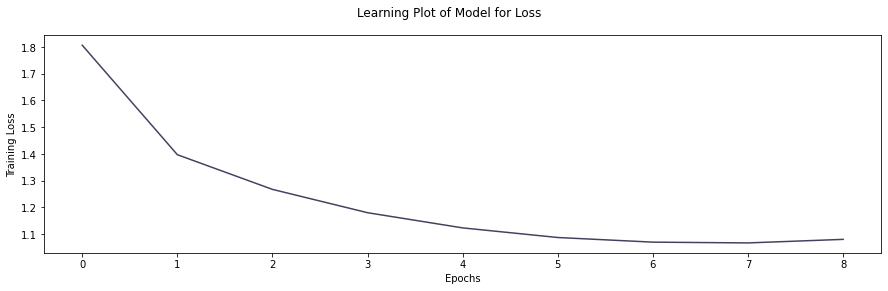

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")